In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
#sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac//') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '../SyMBac/')

from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.colony_simulation import ColonySimulation
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
from glob import glob
import shutil
from skimage.transform import rotate
import os

/home/gh464/Documents/GitHub/SyMBac/SyMBac/colony_simulation.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import global_params

In [1]:
colonysim = ColonySimulation(
    cellmodeller_model= global_params.cellmodeller_model,
    max_cells = global_params.max_cells,
    pix_mic_conv = global_params.pix_mic_conv,
    resize_amount = global_params.resize_amount,
    save_dir = "test/"
)
print(colonysim.get_simulation_dirs())
_ = (colonysim.get_simulation_pickles())
colonysim.get_max_scene_size()

def get_uniform_var(a, b):
    return 1/12 * (b - a)**2

def get_uniform_mean(a, b):
    return 1/2 * (a+b)

mean_density_modifier = 5
import numpy as np
import matplotlib.pyplot as plt

n_CVs = 11
pos_dev = np.linspace(0,mean_density_modifier-0.01,n_CVs)
neg_dev = -np.linspace(0,mean_density_modifier,n_CVs)
print(pos_dev, neg_dev)
lower_bound = mean_density_modifier - pos_dev
upper_bound = mean_density_modifier - neg_dev
print(lower_bound, upper_bound)

var = get_uniform_var(lower_bound, upper_bound)
mean = get_uniform_mean(lower_bound, upper_bound)
CVs = var/(mean**2)
plt.scatter(range(len(CVs)), CVs)

NameError: name 'ColonySimulation' is not defined

In [53]:
samples = np.random.normal(1, np.sqrt(2), 1000)

In [58]:
[x if x > 0 else 0 for x in samples ]

[1.9317367167127721,
 2.140526639655927,
 0.23915099399255257,
 2.6527341002356826,
 0,
 1.9719897694050892,
 2.455569350388874,
 1.8880331389453167,
 2.0702087866399776,
 2.1888787666936724,
 0,
 3.962904521616364,
 0.873410518030385,
 0.10465886400141478,
 2.856715352359503,
 1.9969849056933229,
 3.0495961309381094,
 0.3727534426074356,
 0.47575127639446213,
 3.0457320343232874,
 0,
 2.8167067940774206,
 0.13633203826682116,
 0.3414353669329231,
 0.8516209616785217,
 1.249600565829625,
 0.9743790903998607,
 0.4259603797938457,
 0,
 1.3932067147307643,
 0.8401940882298969,
 1.5362018665225055,
 3.475257862205427,
 0,
 1.5438222390808933,
 0,
 2.63224824542222,
 0.06203210236968504,
 1.8911169042523979,
 1.2033758650420856,
 2.399079255657047,
 0.32832116187302873,
 0,
 1.8189582131569186,
 3.1389397075515677,
 0.01587628682028208,
 0,
 1.3449269113658366,
 0.8007458642331808,
 0,
 0,
 1.4906239077243997,
 0,
 1.5175978326060933,
 1.2196866460944022,
 2.4171563081854726,
 2.71271359919

In [5]:
mean

array([10.    , 10.0005, 10.001 , 10.0015, 10.002 , 10.0025, 10.003 ,
       10.0035, 10.004 , 10.0045, 10.005 ])

In [5]:
#for a, b in tqdm(zip(lower_bound, upper_bound), total = len(upper_bound)):
#    colonysim.draw_simulation_OPL(n_jobs = -1, FL=True, density = 0.1, random_distribution = "uniform", distribution_args = (a, b), as_3D = True, crop=True, crop_pad=50)

In [6]:
from SyMBac.colony_renderer import ColonyRenderer

In [7]:
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


In [8]:
try:
    os.mkdir("simulated_colonies")
except:
    pass

In [9]:
## Large simulation space, narrowed down for final analysis
#NAs = np.linspace(0.5, 1.49, 5)
#ns = np.linspace(1, 1.518, 5)
#wavelengths = [0.45, 0.5, 0.575,  0.65]
#names = ["blue", "green", "orange", "far red"]

NAs = list(reversed([1.49, 0.95, 0.75]))
ns = list(reversed([1.518, 1.0, 1.0]))
working_distances = list(reversed([170, 570, 1000]))
wavelengths = list(reversed([0.4, 0.55,  0.7]))
names = list(reversed(["blue", "green", "orange", "far red"]))
cell_depth = 1 #micron

In [10]:
sim_params = [
    (v, u, t) 
    for v, u in zip(NAs, ns)
    for t in wavelengths]
len(sim_params)

9

  0%|          | 0/9 [00:00<?, ?it/s]

1.49 1.518 170 0.4


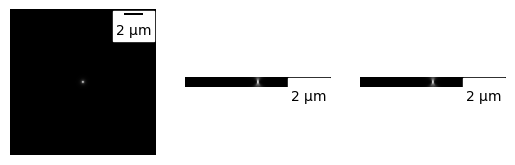

3476


2023-03-26 04:34:45,215	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-03-26 04:34:46,160	WARNING worker.py:1866 -- Warning: The remote function SyMBac.colony_renderer.run_on_GPU is very large (15 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [11]:
pbar = tqdm(total = len(sim_params))
for wavelength, name in zip(wavelengths, names):
    for NA, n, working_distance in zip(NAs, ns, working_distances):
        if glob(f"simulated_colonies/training_data_100x_{wavelength}_{name}_{NA}_{n}"):
            pass
        else:
            print(NA, n, working_distance, wavelength)
            my_kernel = PSF_generator(
                radius = 150, 
                wavelength = wavelength, 
                NA=NA, 
                n = n, 
                resize_amount=global_params.resize_amount, 
                pix_mic_conv=global_params.pix_mic_conv, 
                apo_sigma = 10, 
                mode="3d fluo", 
                condenser="Ph3", 
                z_height = int(round(1/global_params.pix_mic_conv)),
                pz = 0.5,
                working_distance = working_distance
            )
            my_kernel.calculate_PSF()
            #my_kernel.kernel = np.sum(my_kernel.kernel, axis=0) # take the projection, it makes basically no difference compared to 3D convolution
            my_kernel.kernel /= np.sum(my_kernel.kernel) # normalise so kernel sums to 1
            my_kernel.plot_PSF()
            # Commented out kernel offset and offset apodisation as difficult to justify other than "images seem more realistic"
            #my_kernel.kernel += 0.006
            #my_kernel.kernel *= PSF_generator.gaussian_2D(300, 70)

            my_renderer = ColonyRenderer(colonysim, my_kernel)
            print(len(my_renderer.OPL_dirs))
            my_renderer.generate_random_samples(len(my_renderer.OPL_dirs), 0, f"simulated_colonies/training_data_100x_{wavelength}_{name}_{NA}_{n}", GPUs=[0,1], n_jobs = 1, gpu_fraction=0.5, batch_size = 50)
            pbar.update()
pbar.close()

In [12]:
wavelength = 0.7
name = "far red"
NA = 1.49
n = 1.518

glob(f"simulated_colonies/training_data_100x_{wavelength}_{name}_{NA}_{n}")

['simulated_colonies/training_data_100x_0.7_far red_1.49_1.518']

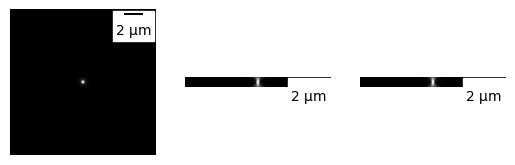

In [13]:
my_kernel = PSF_generator(
    radius = 150, 
    wavelength = wavelength, 
    NA=NA, 
    n = n, 
    resize_amount=global_params.resize_amount, 
    pix_mic_conv=global_params.pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph1", 
    z_height = 22,
    pz = 0.5,
    working_distance=170
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

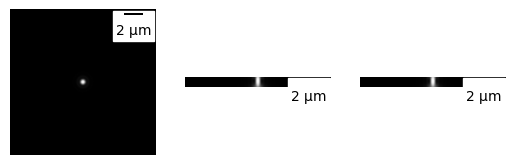

In [14]:
my_kernel = PSF_generator(
    radius = 150, 
    wavelength = wavelength, 
    NA=0.95, 
    n = 1, 
    resize_amount=global_params.resize_amount, 
    pix_mic_conv=global_params.pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = 22,
    pz = 0.5,
    working_distance=570
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()